In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
train=fetch_20newsgroups(subset='train')
test=fetch_20newsgroups(subset='test')

In [2]:
from nltk.tokenize import word_tokenize
word_data_train=list(map(word_tokenize,train['data']))
word_data_test=list(map(word_tokenize,test['data']))

In [3]:
from gensim.models.fasttext import FastText

In [4]:
model = FastText(word_data_train,size=10,window=5,max_vocab_size=2000,sg=1,negative=5)

In [5]:
model.wv['I']

array([ 0.14756131,  0.45004416,  0.02333481,  0.18570551, -0.13974707,
        0.02086684,  0.12455039, -0.21546963, -0.45255548, -0.05966334], dtype=float32)

In [6]:
model.wv['I'].shape

(10,)

In [7]:
model.wv.most_similar(positive=['I'])

[('sure', 0.9132096767425537),
 ('like', 0.881662905216217),
 ('i', 0.8732050657272339),
 ('trying', 0.8693819642066956),
 ('anyone', 0.8651167154312134),
 ('if', 0.852983832359314),
 ('me', 0.8493496775627136),
 ('am', 0.8489735126495361),
 ('just', 0.8431988954544067),
 ("'m", 0.836645245552063)]

In [8]:
model.wv.most_similar_cosmul(positive=['I'])

[('sure', 0.9566039443016052),
 ('like', 0.9408305287361145),
 ('i', 0.9366016387939453),
 ('trying', 0.9346900582313538),
 ('anyone', 0.9325574636459351),
 ('if', 0.9264910221099854),
 ('me', 0.9246739745140076),
 ('am', 0.9244858622550964),
 ('just', 0.9215985536575317),
 ("'m", 0.9183217883110046)]

### 「和を取るだけ」を試す

In [9]:
import tqdm

In [10]:
train_vectors=np.zeros((len(word_data_train),10))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        train_vectors[i]+=model.wv[word]

  0%|          | 0/11314 [00:00<?, ?it/s]


KeyError: 'all ngrams for word WHAT absent from model'

- 見た目は違うが同じエラー。

In [11]:
wordset=set(model.wv.vocab.keys())

In [12]:
train_vectors=np.zeros((len(word_data_train),10))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        if word in wordset:
            train_vectors[i]+=model.wv[word]

100%|██████████| 11314/11314 [00:21<00:00, 531.60it/s]


In [13]:
test_vectors=np.zeros((len(word_data_test),10))

for i,words in enumerate(tqdm.tqdm(word_data_test)):
    for word in words:
        if word in wordset:
            test_vectors[i]+=model.wv[word]

100%|██████████| 7532/7532 [00:13<00:00, 573.52it/s]


### 分類

In [14]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
clf_list=[RidgeClassifier(),RandomForestClassifier(n_estimators=100)]
clf_names=['L2正則化つきの線形分類器','ランダムフォレスト']

for name,clf in zip(clf_names,clf_list):
    clf.fit(train_vectors,train['target'])
    print(name,'：',clf.score(test_vectors,test['target']))

L2正則化つきの線形分類器 ： 0.133430695698
ランダムフォレスト ： 0.176447158789


- 参考記録：BOW
    - L2正則化つきの線形分類器 ： 0.629978757302
    - ランダムフォレスト ： 0.699548592671
    - rbfカーネルのSVM ： 0.502389803505
    - 2次の多項カーネルのSVM ： 0.0677110993096

### idf追加

In [16]:
count_dict={}
for words in word_data_train:
    for word in set(words):
        count_dict[word]=count_dict.get(word,0)+1
count_dict

{'rac3.wam.umd.edu': 6,
 'It': 3389,
 'early': 340,
 'wam.umd.edu': 27,
 'looking': 761,
 'other': 2778,
 'This': 2671,
 '60s/': 2,
 'name': 681,
 '.': 11039,
 'Nntp-Posting-Host': 2455,
 'looked': 271,
 'history': 355,
 'Lerxst': 2,
 '!': 4472,
 'out': 3473,
 'there': 3774,
 'IL': 108,
 'my': 3850,
 'of': 9821,
 'really': 1478,
 'can': 4432,
 'doors': 69,
 '15': 835,
 'info': 514,
 'years': 1269,
 'body': 297,
 'day': 819,
 '(': 11054,
 'neighborhood': 26,
 'funky': 6,
 'be': 6387,
 ':': 11314,
 'thing': 1163,
 'have': 6697,
 'If': 3232,
 'small': 572,
 'a': 9705,
 'tellme': 2,
 'where': 1614,
 '@': 11306,
 'University': 4390,
 '2-door': 5,
 'Lines': 11276,
 ')': 11064,
 'The': 5873,
 'called': 774,
 "'s": 5842,
 'e-mail': 460,
 'Organization': 10854,
 'Subject': 11314,
 '-': 4484,
 'were': 2322,
 'know': 3256,
 'me': 3794,
 'specs': 98,
 'bumper': 25,
 'to': 9824,
 'front': 309,
 'all': 3959,
 'sports': 77,
 'Maryland': 97,
 'Thanks': 1455,
 'anyone': 1835,
 'saw': 359,
 'whatever': 

In [18]:
idf_dict={}
N=len(word_data_train)

for key in count_dict:
    idf_dict[key]=np.log(N/count_dict[key])
idf_dict

{'rac3.wam.umd.edu': 7.542036706675046,
 'It': 1.2055060042960497,
 'early': 3.5048505582928939,
 'wam.umd.edu': 6.0379593098987723,
 'looking': 2.6991628180414153,
 'other': 1.4043096525888119,
 'This': 1.4435879627931403,
 '60s/': 8.640648995343156,
 'name': 2.8102338697535885,
 '.': 0.024606439884749289,
 'Nntp-Posting-Host': 1.5279141356744801,
 'looked': 3.7316773550233999,
 'history': 3.4616783864276854,
 'Lerxst': 8.640648995343156,
 '!': 0.92820516106816586,
 'out': 1.181022123159027,
 'there': 1.0979054499746055,
 'IL': 4.6516649487788815,
 'my': 1.0779677486212711,
 'of': 0.14151794674532675,
 'really': 2.0353510743949541,
 'can': 0.93718994747598117,
 'doors': 5.0996896713058417,
 '15': 2.6063644510522455,
 'info': 3.0915729104479359,
 'years': 2.1878117081887134,
 'body': 3.6400640371004016,
 'day': 2.6257120920500316,
 '(': 0.023248543509892711,
 'neighborhood': 6.0756996378816188,
 'funky': 7.542036706675046,
 'be': 0.57177622234151182,
 ':': 0.0,
 'thing': 2.275038023384

In [19]:
train_vectors=np.zeros((len(word_data_train),10))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        if word in wordset:
            train_vectors[i]+=model.wv[word]*idf_dict[word]

100%|██████████| 11314/11314 [00:38<00:00, 297.45it/s]


In [20]:
test_vectors=np.zeros((len(word_data_test),10))

for i,words in enumerate(tqdm.tqdm(word_data_test)):
    for word in words:
        if word in wordset:
            test_vectors[i]+=model.wv[word]*idf_dict[word]

100%|██████████| 7532/7532 [00:19<00:00, 380.84it/s]


In [21]:
clf_list=[RidgeClassifier(),RandomForestClassifier(n_estimators=100)]
clf_names=['L2正則化つきの線形分類器','ランダムフォレスト']

for name,clf in zip(clf_names,clf_list):
    clf.fit(train_vectors,train['target'])
    print(name,'：',clf.score(test_vectors,test['target']))

L2正則化つきの線形分類器 ： 0.123605947955
ランダムフォレスト ： 0.203133297929


### 単語数を減らさない

In [22]:
model = FastText(word_data_train,sg=1)

In [23]:
wordset=set(model.wv.vocab.keys())

train_vectors=np.zeros((len(word_data_train),model.vector_size))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        if word in wordset:
            train_vectors[i]+=model.wv[word]
            
            
test_vectors=np.zeros((len(word_data_test),model.vector_size))

for i,words in enumerate(tqdm.tqdm(word_data_test)):
    for word in words:
        if word in wordset:
            test_vectors[i]+=model.wv[word]

100%|██████████| 7532/7532 [00:17<00:00, 434.08it/s]


In [24]:
clf_list=[RidgeClassifier(),RandomForestClassifier(n_estimators=100)]
clf_names=['L2正則化つきの線形分類器','ランダムフォレスト']

for name,clf in zip(clf_names,clf_list):
    clf.fit(train_vectors,train['target'])
    print(name,'：',clf.score(test_vectors,test['target']))

L2正則化つきの線形分類器 ： 0.49522039299
ランダムフォレスト ： 0.486723313861


### そしてidf

In [25]:
wordset=set(model.wv.vocab.keys())

train_vectors=np.zeros((len(word_data_train),model.vector_size))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        if word in wordset:
            train_vectors[i]+=model.wv[word]*idf_dict[word]
            
            
test_vectors=np.zeros((len(word_data_test),model.vector_size))

for i,words in enumerate(tqdm.tqdm(word_data_test)):
    for word in words:
        if word in wordset:
            test_vectors[i]+=model.wv[word]*idf_dict[word]

100%|██████████| 7532/7532 [00:22<00:00, 333.17it/s]


In [26]:
clf_list=[RidgeClassifier(),RandomForestClassifier(n_estimators=100)]
clf_names=['L2正則化つきの線形分類器','ランダムフォレスト']

for name,clf in zip(clf_names,clf_list):
    clf.fit(train_vectors,train['target'])
    print(name,'：',clf.score(test_vectors,test['target']))

L2正則化つきの線形分類器 ： 0.530270844397
ランダムフォレスト ： 0.564790228359


In [28]:
clf=RandomForestClassifier(n_estimators=1000,verbose=1)
clf.fit(train_vectors,train['target'])
print(name,'：',clf.score(test_vectors,test['target']))

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.5s finished


ランダムフォレスト ： 0.585767392459


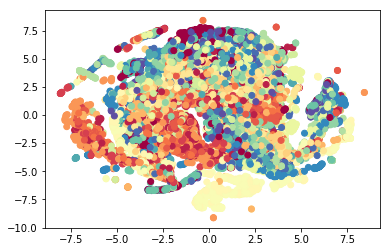

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
tsne=TSNE()
emb=tsne.fit_transform(train_vectors)
plt.scatter(*emb.T,c=train['target'],cmap='Spectral')